# Coronary Heart Disease Model 

Goal = predict probability of risk of CHD in 10 years (TenYearCHD variable) \
Method = use a short decision tree to find the variables that are most predictive of CHD risk, then interact and regress on those to get a prediction. 

In [1]:
# import packages

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn as sns

## import and prep data

In [2]:
# import data 

train_df = pd.read_csv("clean_chd_train.csv", low_memory = False)
test_df = pd.read_csv("clean_chd_test.csv", low_memory = False)

In [3]:
# split train data into variable matrix and result vector

# result vector
y_train = train_df['TenYearCHD']

# variable matrix
columns = ['Unnamed: 0', 'education', 'TenYearCHD', 'sex_category', 'smoker_category', 'BPMeds_category', 
           'stroke_category', 'hyp_category', 'diabetes_category', 'chd_category']
X_train = train_df.drop(columns=columns)

# concat with dummies for education level
edu_dummies = pd.get_dummies(X_train['edu_category'], dtype='int')
X_train = pd.concat([X_train,edu_dummies], axis=1)
X_train = X_train.drop(columns=['edu_category'])

In [4]:
# do the same thing for the test data

# result vector
y_test = test_df['TenYearCHD']

# variable matrix
columns = ['Unnamed: 0', 'education', 'TenYearCHD', 'sex_category', 'smoker_category', 'BPMeds_category', 
           'stroke_category', 'hyp_category', 'diabetes_category', 'chd_category']
X_test = test_df.drop(columns=columns)

# concat with dummies for education level
edu_dummies = pd.get_dummies(X_test['edu_category'], dtype='int')
X_test = pd.concat([X_test, edu_dummies], axis=1)
X_test = X_test.drop(columns=['edu_category'])

In [5]:
X_train.head()

,sex,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,HS/GED,college,some HS,some college/vocation
0,1,58,0,0,0,0,0,0,220,143.0,104.0,29.85,75,87,0,0,1,0
1,0,40,1,15,0,0,0,0,199,122.0,82.0,22.16,85,77,0,0,1,0
2,0,52,0,0,0,0,0,0,275,112.0,71.0,25.68,80,78,0,0,1,0
3,1,38,1,43,0,0,1,0,170,130.0,94.0,23.90,110,75,1,0,0,0
4,0,43,0,0,0,0,0,0,202,124.0,92.0,21.26,75,74,0,0,1,0


## initial decision tree

[Text(0.4375, 0.9, 'age <= 48.5\ngini = 0.259\nsamples = 3058\nvalue = [2590, 468]'),
 Text(0.20833333333333334, 0.7, 'cigsPerDay <= 9.5\ngini = 0.145\nsamples = 1513\nvalue = [1394, 119]'),
 Text(0.125, 0.5, 'diaBP <= 98.25\ngini = 0.087\nsamples = 808\nvalue = [771, 37]'),
 Text(0.08333333333333333, 0.3, 'BMI <= 22.895\ngini = 0.074\nsamples = 758\nvalue = [729, 29]'),
 Text(0.041666666666666664, 0.1, 'gini = 0.009\nsamples = 211\nvalue = [210, 1]'),
 Text(0.125, 0.1, 'gini = 0.097\nsamples = 547\nvalue = [519, 28]'),
 Text(0.16666666666666666, 0.3, 'gini = 0.269\nsamples = 50\nvalue = [42, 8]'),
 Text(0.2916666666666667, 0.5, 'sysBP <= 150.25\ngini = 0.206\nsamples = 705\nvalue = [623, 82]'),
 Text(0.25, 0.3, 'age <= 40.5\ngini = 0.191\nsamples = 655\nvalue = [585, 70]'),
 Text(0.20833333333333334, 0.1, 'gini = 0.12\nsamples = 234\nvalue = [219, 15]'),
 Text(0.2916666666666667, 0.1, 'gini = 0.227\nsamples = 421\nvalue = [366, 55]'),
 Text(0.3333333333333333, 0.3, 'gini = 0.365\nsamp

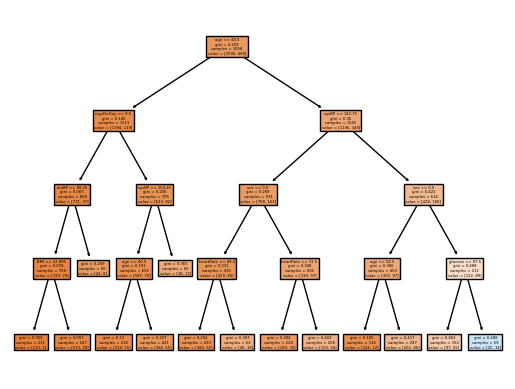

In [6]:
# fit decision tree

cart = DecisionTreeClassifier(max_depth=4,min_samples_leaf=50) # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier
var_names = list(cart.feature_names_in_)

# visualize results
plot_tree(cart,filled=True,feature_names=var_names) 

## selection of variables 

I did several iterations of the decision tree and different regressions in order to select important variables and their interactions.  

First I ran a tree with a max depth of 3, and the minimum leaf sample of 50. These were just arbitary numbers I chose. 
The important variables from this tree were age, cigsPerDay, diaBP, sysBP, and sex. Without winsorizing the outliers, the R^2 was 0.0888, and with winsorizing, the R^2 increased to 0.0892. With winsorizing and interacting all the variables with degree 2, the R^2 increased to 0.1091. 

Then, just to see the difference, I ran a tree with a max depth of 3 with no specification on minimum leaf sample. The important variables from this tree were age, glucose, sysBP, totChol, sex, and prevalentHyp. With no outlier modification or interaction, the R^2 was 0.0825, with winsorization, the R^2 was 0.0830. With windsorizing and interacting all the variables with degree 2, the R^2 dropped to -0.1712. 

Then I ran a tree with a max depth of 4, with no no specification on minimum leaf sample. The important variables from this tree were age, glucose, cigsPerDay, BMI, sysBP, and sex. Without winsorizing or expanding, the R^2 on a regression for this set was 0.0947. With winsorizing but still no interaction, the R^2 was 0.0942. With winsorizing and interacting all variables, the R^2 was -0.2413. 

I also ran a tree with a max depth of 4, and the minimum leaf sample of 50. The important variables from this tree were age, cigsPerDay, diaBP, BMI, sysBP, sex, heartRate, and glucose. A regression with no modification of this set had an R^2 of 0.0938. With winsorizing, the R^2 was 0.0930. With winsorizing and interacting with degree 2, the R^2 dropped to -0.296. 

After these models, I saw that the best models so far was interacting age, cigsPerDay, diaBP, sysBP, and sex (first model) and no interacting age, glucose, cigsPerDay, BMI, sysBP, and sex (3rd model) or no interacting age, cigsPerDay, diaBP, BMI, sysBP, sex, heartRate, and glucose (4th model). Thus I decided to combine these models, taking the variables age, cigsPerDay, diaBP, sysBP, sex, BMI, heartRate, and glucose. I winsorized to control the outliers, and then expanded to interact the subset from the first model (age, cigsPerDay, diaBP, sysBP, and sex). I then added in the additional variables from the 3rd and 4th models, without interacting them (BMI, heartRate, glucose). Regressing on this combination resulted in an R^2 of 0.1132, which is the highest I found. 

It was very difficult to get any sort of "high" R^2 on this data, even a simple random forest regression for comparison only gave a R^2 of 0.0427. 

In [7]:
# select important columns based on decision tree 

X_train_subset = X_train.loc[:,['age','cigsPerDay','diaBP','BMI','sysBP','sex','heartRate','glucose']]
X_test_subset = X_test.loc[:,['age','cigsPerDay','diaBP','BMI','sysBP','sex','heartRate','glucose']]

<Axes: >

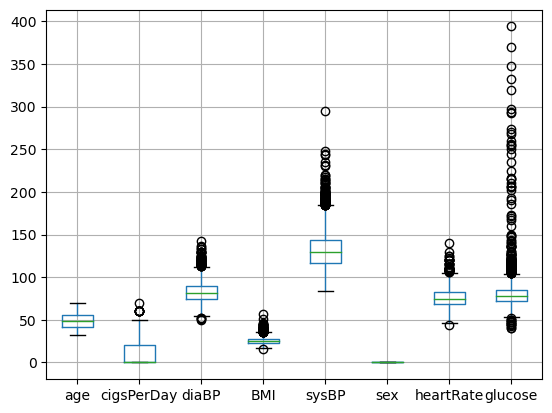

In [8]:
# plot data to identify outliers 

X_train_subset.boxplot()

In [9]:
# winsorize data to control outliers

def winsorize(x):
    # Convert from pd to np, if necessary:
    if max(x) != 1: # if variable is not binary 1 or 0 
        if type(x) == 'pandas.core.series.Series':
            x = x.to_numpy()
        # Compute IQR and 25, 75 quantiles:
        pct25, pct75 = np.percentile(x,[25,75])
        iqr = pct75 - pct25
        # Compute whiskers:
        lower_whisker = pct25 - iqr*1.5
        upper_whisker = pct75 + iqr*1.5
        # Windorize x:
        x_winsor = np.copy(x)
        x_winsor[ x < lower_whisker ] = lower_whisker
        x_winsor[ x > upper_whisker ] = upper_whisker
        return(x_winsor)
    else:
        return x
    
X_train_subset = X_train_subset.apply(winsorize)

<Axes: >

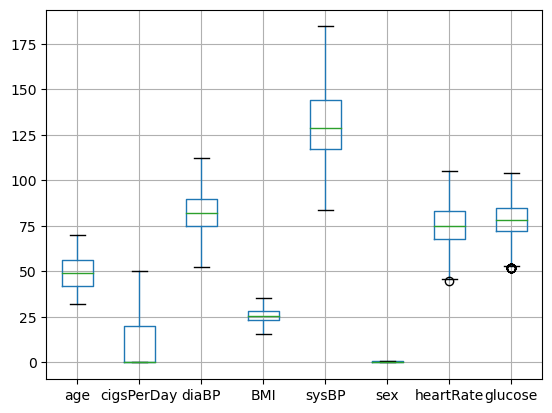

In [10]:
# check outliers - there are a lot less

X_train_subset.boxplot()

In [11]:
# use the expander to find the interactions between variables 

expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_subset.loc[:,['age','cigsPerDay','diaBP','sysBP','sex']]) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_subset2 = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

Z_test = expander.fit_transform(X_test_subset.loc[:,['age','cigsPerDay','diaBP','sysBP','sex']])
X_test_subset2 = pd.DataFrame(data=Z_test, columns = names)

In [12]:
# combine expanded and not expanded variables

X_train_subset = pd.concat([X_train_subset2,X_train_subset.loc[:,['BMI','heartRate','glucose']]],axis=1)
X_test_subset = pd.concat([X_test_subset2,X_test_subset.loc[:,['BMI','heartRate','glucose']]],axis=1)

In [13]:
# check work 

X_train_subset.head()

,age,cigsPerDay,diaBP,sysBP,sex,age^2,age cigsPerDay,age diaBP,age sysBP,age sex,...,cigsPerDay sex,diaBP^2,diaBP sysBP,diaBP sex,sysBP^2,sysBP sex,sex^2,BMI,heartRate,glucose
0,58.0,0.0,104.0,143.0,1.0,3364.0,0.0,6032.0,8294.0,58.0,...,0.0,10816.0,14872.0,104.0,20449.0,143.0,1.0,29.85,75,87
1,40.0,15.0,82.0,122.0,0.0,1600.0,600.0,3280.0,4880.0,0.0,...,0.0,6724.0,10004.0,0.0,14884.0,0.0,0.0,22.16,85,77
2,52.0,0.0,71.0,112.0,0.0,2704.0,0.0,3692.0,5824.0,0.0,...,0.0,5041.0,7952.0,0.0,12544.0,0.0,0.0,25.68,80,78
3,38.0,43.0,94.0,130.0,1.0,1444.0,1634.0,3572.0,4940.0,38.0,...,43.0,8836.0,12220.0,94.0,16900.0,130.0,1.0,23.90,105,75
4,43.0,0.0,92.0,124.0,0.0,1849.0,0.0,3956.0,5332.0,0.0,...,0.0,8464.0,11408.0,0.0,15376.0,0.0,0.0,21.26,75,74


In [14]:
# fit linear model and output R squared 

reg = linear_model.LinearRegression().fit(X_train_subset,y_train) # Run regression
y_hat = reg.predict(X_test_subset)
print("R squared on test:", reg.score(X_test_subset, y_test))

R squared on test: 0.11323369050347043


<Axes: xlabel='TenYearCHD', ylabel='Density'>

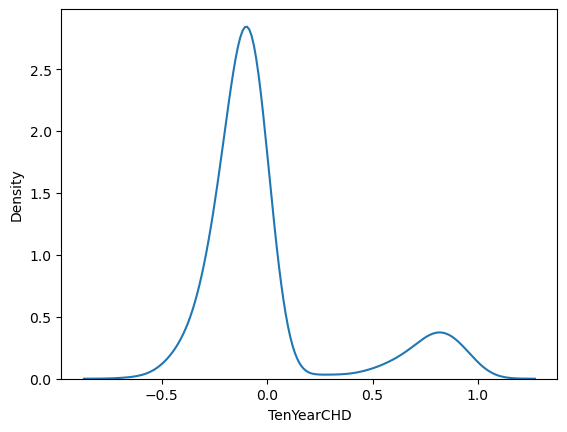

In [15]:
# kernel density plot of residuals 

sns.kdeplot(y_test-y_hat)

#### random forest for comparable R^2

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Fit model:
model = RandomForestRegressor() # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

# Rsq measure
rf.score(X_test,y_test) 

0.04274005906040279